In [671]:
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta

pd.options.display.max_columns = 99
%matplotlib inline

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

# 2024 US Election Model

In [610]:
electoral_college = {
    "Alabama": 9,
    "Alaska": 3,
    "Arizona": 11,
    "Arkansas": 6,
    "California": 54,
    "Colorado": 10,
    "Connecticut": 7,
    "District of Columbia": 3,
    "Delaware": 3,
    "Florida": 30,
    "Georgia": 16,
    "Hawaii": 4,
    "Idaho": 4,
    "Illinois": 19,
    "Indiana": 11,
    "Iowa": 6,
    "Kansas": 6,
    "Kentucky": 8,
    "Louisiana": 8,
    "Maine": 4,
    "Maryland": 10,
    "Massachusetts": 11,
    "Michigan": 15,
    "Minnesota": 10,
    "Mississippi": 6,
    "Missouri": 10,
    "Montana": 4,
    "Nebraska": 5,
    "Nevada": 6,
    "New Hampshire": 4,
    "New Jersey": 14,
    "New Mexico": 5,
    "New York": 28,
    "North Carolina": 16,
    "North Dakota": 3,
    "Ohio": 17,
    "Oklahoma": 7,
    "Oregon": 8,
    "Pennsylvania": 19,
    "Rhode Island": 4,
    "South Carolina": 9,
    "South Dakota": 3,
    "Tennessee": 11,
    "Texas": 40,
    "Utah": 6,
    "Vermont": 3,
    "Virginia": 13,
    "Washington": 12,
    "West Virginia": 4,
    "Wisconsin": 10,
    "Wyoming": 3,
}

# 538
total_ev = sum(electoral_college.values())
# 270
ev_majority = (total_ev // 2) + 1

In [330]:
url = "https://projects.fivethirtyeight.com/polls/data/president_polls.csv"
polling_data = pd.read_csv(url)

def parse_date(date_: str) -> date:
    month, day, year = date_.split("/")
    start_date = date(int("20" + year), int(month), int(day))
    return start_date
   

for col in ["start_date", "end_date"]:
    polling_data[col] = polling_data[col].map(parse_date)
    
polling_data["pct"] = polling_data["pct"] / 100

In [386]:
mask = polling_data["state"].notna()

polls = (
    polling_data[mask]
    .query("party == 'DEM' or party == 'REP'")
    .groupby(["poll_id", "start_date", "party", "state"])
    .agg(pct=("pct", "max"), sample_size=("sample_size", "max"))
    .reset_index()
    .pivot(
        index=["poll_id", "start_date", "sample_size", "state"],
        columns="party",
        values="pct",
    )
    .reset_index()
    .rename_axis(columns=None)
    .rename(columns=lambda x: x.lower())
)

dc_2020 = pd.DataFrame(
    {
        "poll_id": 9999999,
        "start_date": date(2020, 11, 5),
        "sample_size": 330000,
        "state": "District of Columbia",
        "dem": 0.92,
        "rep": 0.05,
    },
    index=[0],
)

polls = pd.concat([polls, dc_2020], ignore_index=True)

def replace_cds(state: str) -> str:
    
    if state.startswith("Maine"):
        return "Maine"
    
    if state.startswith("Nebraska"):
        return "Nebraska"
    
    return state

polls["state"] = polls["state"].map(replace_cds)

In [390]:
average_sample_size = (
    polls
    .groupby("state")
    .agg(sample_size=("sample_size", "mean"))
    .to_dict()["sample_size"]
)

def fill_missing_sample_size(poll: pd.Series) -> float:
    if pd.isnull(poll["sample_size"]):
        return average_sample_size[poll["state"]]
    
    return poll["sample_size"]


polls["sample_size"] = polls.apply(fill_missing_sample_size, axis=1)

In [464]:
def softmax(scores: np.array) -> np.array:
    exp_scores = np.exp(scores.astype("float64"))
    return exp_scores / np.sum(exp_scores)

polls.loc[:, ["softmax_dem", "softmax_rep"]] = np.apply_along_axis(
    softmax, 1, polls[["dem", "rep"]].values
)

In [465]:
last_poll_dates = (
    polls
    .groupby("state")
    .agg(last_poll_date=("start_date", "max"))
    .to_dict()["last_poll_date"]
)

lmbd = 0.01

def get_w(poll: pd.Series) -> float:
    age_days = (last_poll_dates[poll["state"]] - poll["start_date"]).days
    w = np.exp(-lmbd * age_days) * poll["sample_size"]
    return w

polls["w"] = polls.apply(get_w, axis=1)

In [466]:
polls.head(10)

,poll_id,start_date,sample_size,state,dem,rep,w,softmax_dem,softmax_rep
0,74706,2021-04-21,933.0,Missouri,0.380,0.530,0.003843,0.462570,0.537430
1,74928,2021-05-07,1267.0,New Hampshire,0.510,0.430,0.006124,0.519989,0.480011
2,75009,2021-06-17,600.0,Arizona,0.510,0.440,0.004241,0.517493,0.482507
3,75617,2021-08-16,2068.0,Florida,0.480,0.474,0.028278,0.501500,0.498500
4,75620,2021-08-04,700.0,Florida,0.500,0.470,0.008490,0.507499,0.492501
5,76282,2021-09-11,911.0,Florida,0.552,0.448,0.016156,0.525977,0.474023
6,76426,2021-09-18,1014.0,Missouri,0.360,0.550,0.018717,0.452642,0.547358
7,76752,2021-09-16,450.0,Florida,0.512,0.506,0.008390,0.501500,0.498500
8,77034,2021-10-18,600.0,Iowa,0.405,0.541,0.015560,0.466052,0.533948
9,77173,2021-10-26,805.0,Wisconsin,0.450,0.410,0.021086,0.509999,0.490001


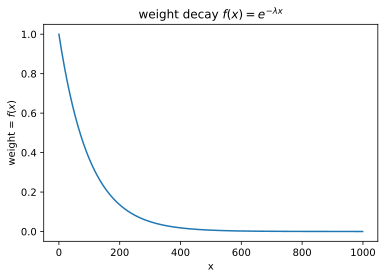

In [693]:
x = np.arange(0, 1000)
plt.plot(x, np.exp(-lmbd * x))
plt.title("weight decay $f(x) = e^{-\lambda x}$")
plt.xlabel("x")
plt.ylabel("weight = $f(x)$")
plt.show()

In [477]:
# https://www.kaggle.com/datasets/tunguz/us-elections-dataset/data
election_data = (
    pd
    .read_csv("~/Downloads/1976-2020-president.csv")
    .query("year >= 2008 and party_detailed in ('DEMOCRAT', 'REPUBLICAN')")
)

In [481]:
elections = (
    election_data
    .groupby(["year", "state", "party_detailed"])
    .agg(
        votes=("candidatevotes", "sum"),
        total_votes=("totalvotes", "sum"),
    )
    .reset_index()
)
elections["state"] = (
    elections["state"]
    .str.lower()
    .str.title()
    .str.replace("Of", "of")
)
elections["pct"] = elections["votes"] / elections["total_votes"]
elections["party_detailed"] = elections["party_detailed"].map(
    lambda p: "dem" if p == "DEMOCRAT" else "rep"
)

elections = (
    elections
    .pivot(
        index=["year", "state"],
        columns="party_detailed",
        values="pct"
    )
    .reset_index()
    .rename_axis(columns=None)
)

mask = (
    (elections["year"] == 2012)
    & (elections["state"] == "Minnesota")
)

elections.loc[mask, ["dem", "rep"]] = [0.5265, 0.4496]

elections.loc[:, ["softmax_dem", "softmax_rep"]] = np.apply_along_axis(
    softmax, 1, elections[["dem", "rep"]].values
)

In [482]:
elections.head()

,year,state,dem,rep,softmax_dem,softmax_rep
0,2008,Alabama,0.387404,0.603169,0.446267,0.553733
1,2008,Alaska,0.378894,0.594245,0.446369,0.553631
2,2008,Arizona,0.451153,0.536352,0.478713,0.521287
3,2008,Arkansas,0.388647,0.587159,0.450534,0.549466
4,2008,California,0.610126,0.369549,0.559856,0.440144


In [524]:
state_covariance = (
    elections
    .pivot(index="year", columns="state", values="softmax_dem")
    .cov(min_periods=4)
)

In [525]:
state_covariance.iloc[:7, :7]

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut
state,,,,,,,
Alabama,0.000050,-0.000045,0.000100,0.000053,-0.000059,0.000003,0.000047
Alaska,-0.000045,0.000140,0.000078,-0.000093,0.000054,0.000035,-0.000041
Arizona,0.000100,0.000078,0.000753,0.000029,-0.000075,0.000217,0.000203
Arkansas,0.000053,-0.000093,0.000029,0.000077,-0.000063,-0.000014,0.000049
California,-0.000059,0.000054,-0.000075,-0.000063,0.000075,0.000020,-0.000038
Colorado,0.000003,0.000035,0.000217,-0.000014,0.000020,0.000097,0.000063
Connecticut,0.000047,-0.000041,0.000203,0.000049,-0.000038,0.000063,0.000087


In [652]:
def get_state_average(
    polls: pd.DataFrame,
    cutoff_date: date | None = None,
) -> pd.DataFrame:
    
    if cutoff_date:
        mask = polls["start_date"] <= cutoff_date
        polls_ = polls[mask]
    else:
        polls_ = polls
    
    return (
        polls_
        .groupby("state")
        .apply(
            lambda s: np.average(s["softmax_dem"], weights=s["w"]),
            include_groups=False
        )
    )

In [654]:
state_average = get_state_average(polls)
state_average.head(10)

state
Alabama                 0.438008
Alaska                  0.482263
Arizona                 0.493847
Arkansas                0.463451
California              0.556963
Colorado                0.525574
Connecticut             0.539423
Delaware                0.524730
District of Columbia    0.704746
Florida                 0.487227
dtype: float64

In [655]:
def simulate_elections(
    state_average: pd.Series,
    state_covariance: pd.DataFrame,
    iterations: int = 10_000

) -> pd.Series:    
    states = state_average.index.tolist()
    mean = state_average.values
    cov = state_covariance.loc[states, states].values

    simulation = np.random.multivariate_normal(mean, cov, size=iterations)
    return pd.DataFrame(simulation, columns=states)

In [656]:
def evaluate_electoral_college(simulated_election: pd.Series) -> int:
    dem_electoral_votes = [
        ev if simulated_election[state] > 0.5 else 0
        for state, ev in electoral_college.items()
    ]
    return sum(dem_electoral_votes)

In [657]:
simulated_elections = simulate_elections(state_average, state_covariance)
simulated_electoral_votes = simulated_elections.apply(
    evaluate_electoral_college, axis=1
)

In [675]:
def show_ev_distribution(simulated_electoral_votes: pd.Series) -> None:
    
    bins = np.arange(100, 450, 10)   
    counts, _ = np.histogram(simulated_electoral_votes, bins=bins) 
    bins = bins[:-1]
    mask = bins > (total_ev / 2)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.bar(
        bins[mask],
        counts[mask],
        color="none",
        edgecolor="#235d9c",
        linewidth=1,
        width=8,
    )
    ax.bar(
        bins[~mask],
        counts[~mask],
        color="none",
        edgecolor="#a40c2b",
        linewidth=1,
        width=8,
    )
    
    win_pct = round((simulated_electoral_votes >= ev_majority).mean() * 100)

    ax.plot(
        [ev_majority, ev_majority],
        [0, counts.max()],
        linestyle="--",
        color="black",
        label=f"{ev_majority} votes needed to win"
    )

    ax.set_xlabel("Democrat Electoral College Votes")
    ax.set_ylabel("Occurences in the Simulation")
    ax.set_title(f"Probability of Democrats Winning the Election = {win_pct}%")
    plt.legend()
    plt.show()

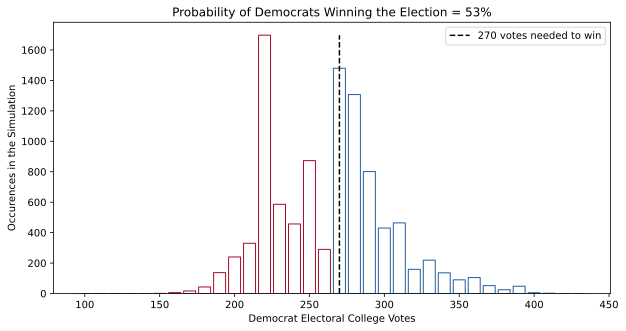

In [676]:
show_ev_distribution(simulated_electoral_votes)

In [694]:
cutoff_dates = sorted(date.today() - timedelta(days=day) for day in range(100))
win_probs = []

for cutoff_date in tqdm.tqdm(cutoff_dates):
    cutoff_state_average = get_state_average(
        polls=polls,
        cutoff_date=cutoff_date
    )
    
    simulated_elections = simulate_elections(
        state_average=cutoff_state_average,
        state_covariance=state_covariance
    )
    
    simulated_electoral_votes = simulated_elections.apply(
        evaluate_electoral_college, axis=1
    )
    
    win_probs.append(
        (simulated_electoral_votes >= ev_majority).mean()
    )

  0%|          | 0/100 [00:00<?, ?it/s]

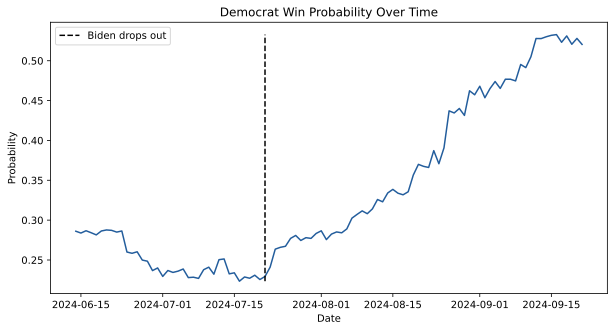

In [695]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(cutoff_dates, win_probs, color="#235d9c")
ax.plot(
    [date(2024, 7, 21)] * 2,
    [min(win_probs), max(win_probs)],
    linestyle="--",
    color="black",
    label="Biden drops out",
)
ax.set_ylabel("Probability")
ax.set_xlabel("Date")
ax.set_title("Democrat Win Probability Over Time")
ax.legend()
plt.show()